# TBiGRU

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import omegaconf
import pytorch_lightning as pl
import rul_datasets

import rul_adapt

# Training preparations

Before training, the TBiGRU approach has a feature mining stage and a bearing running state stage that need to be completed.
The running state detection is used to determine the first-time-to-predict (FTTP) which is needed to appropriately generate the RUL targets.
The RUL Adapt library implements both stages but adds their results to the training configurations for easier an easier replication process (see *Reproduce original configurations* below).

### Feature selection

To run the feature selection stage, create a source and target domain reader and feed them to the `select_features` function.
For each input feature the function extracts 30 different features and returns the indices of the top transferable features.
We select the appropriate runs as training splits and receive the 30 most transferable features out of 60.

In [3]:
source = rul_datasets.FemtoReader(fd=1, run_split_dist={"dev": [1, 7]})
target = rul_datasets.FemtoReader(fd=2, percent_broken=0.8, run_split_dist={"dev": [1, 2]})

feature_idx = rul_adapt.approach.select_features(source, target, num_features=30)
print(sorted(feature_idx))

[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 20, 21, 22, 23, 32, 41, 42, 44, 48, 50, 52, 54, 56, 57, 58, 59]


These feature indices can be used for constructing a domain adaption data module with transferable features.

In [ ]:
extractor = rul_adapt.approach.VibrationFeatureExtractor(num_input_features=2, feature_idx=feature_idx)
extractor.fit(source.load_split("dev")[0] + target.load_split("dev")[0])  # fit internal scaler

dm = rul_datasets.DomainAdaptionDataModule(
    rul_datasets.RulDataModule(source, 32, extractor, 20),
    rul_datasets.RulDataModule(target, 32, extractor, 20),
)

### Running state detection

To set the first-time-to-predict (FTTP) for each bearing, the running states must be detected.
This approach uses the moving average correlation (MAC) between energy entropies of signals decomposed by maximal overlap wavelet decomposition in a sliding window.
We demonstrate this process on Bearing_1_1.

In [4]:
runs, _ = source.load_split("dev")
bearing_1_1 = runs[0]
rms = rul_adapt.approach.tbigru.rms(bearing_1_1)
mac = rul_adapt.approach.tbigru.mac(bearing_1_1, 100, "haar")

In [5]:
def smooth(inputs, alpha):
    """Produce smoothed version of input signal."""
    filtered = np.empty_like(inputs)
    curr = inputs[0]
    for i, update in enumerate(inputs):
        curr = alpha * curr + (1-alpha) * update
        filtered[i] = curr

    return filtered

The MAC should first increase to near 1 and then dip down for a brief period.
This marks the end of the running-in state.
The following steady working state ends after a second brief dip.
The end of the steady working state is considered the FTTP.

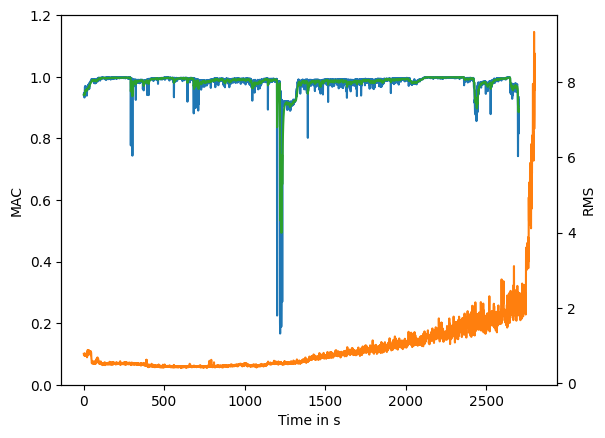

In [9]:
plt.plot(mac)
plt.plot(smooth(mac, 0.8), c="tab:green")
plt.xlabel("Time in s")
plt.ylabel("MAC")
plt.ylim((0, 1.2))
ax = plt.twinx(plt.gca())
ax.plot(rms[:, 0], c="tab:orange")
ax.set_ylabel("RMS")
plt.show()

We can see the raw and smoothed MAC, as well as the RMS.
The plot shows a first dip around 300s and a second dip around 1200s, which would be the first-time-to-predict.
Unfortunately, our implementation does not exactly line up with the original results which is why our FTTPs should be regarded with caution.

## Reproduce original configurations

You can reproduce the original experiments of Cao et al. by using the `get_tbigru` constructor function. Known differences to the original paper:
* The target data is truncated with 80% `percent_broken`.
* The feature selection is carried out separately for each transfer task instead of jointly for all sub-datasets. This is because the target data should be truncated, as noted above. Therefore, a different sub-dataset needs to be truncated for the feature selection for each task, too.
* The first-time-to-predict is likely not correct as the process of determining the running state of the bearing could not be recreated faithfully yet.
In this example, we re-create configuration for adaption FEMTO FD001 to FD002.
Additional kwargs for the trainer, e.g. accelerator="gpu" for training on a GPU, can be passed to this function, too.

In [10]:
pl.seed_everything(42, workers=True)  # make reproducible
dm, tbigru, trainer = rul_adapt.construct.get_tbigru(1, 2, max_epochs=1)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


The networks, `feature_extractor` and `regressor`, can be accessed as properties of the `tbigru` object.

In [11]:
tbigru.feature_extractor

GruExtractor(
  (_fc_layer): Sequential(
    (0): Conv1d(30, 15, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(15, 5, kernel_size=(1,), stride=(1,))
    (3): ReLU()
  )
  (_gru_layers): GRU(5, 5, bidirectional=True)
)

Training is done in the PyTorch Lightning fashion. We used the `trainer_kwargs` to train only one epoch for demonstration purposes.

In [12]:
trainer.fit(tbigru, dm)
trainer.test(tbigru, dm)


   | Name               | Type                       | Params
-------------------------------------------------------------------
0  | train_source_loss  | MeanSquaredError           | 0     
1  | mmd_loss           | MaximumMeanDiscrepancyLoss | 0     
2  | val_source_rmse    | MeanSquaredError           | 0     
3  | val_target_rmse    | MeanSquaredError           | 0     
4  | val_source_score   | RULScore                   | 0     
5  | val_target_score   | RULScore                   | 0     
6  | test_source_rmse   | MeanSquaredError           | 0     
7  | test_target_rmse   | MeanSquaredError           | 0     
8  | test_source_score  | RULScore                   | 0     
9  | test_target_score  | RULScore                   | 0     
10 | _feature_extractor | GruExtractor               | 905   
11 | _regressor         | FullyConnectedHead         | 11    
-------------------------------------------------------------------
916       Trainable params
0         Non-trainable params

Sanity Checking: 0it [00:00, ?it/s]

/home/tilman/Programming/rul-adapt/.venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test/source_rmse        0.6534876227378845
    test/source_score       115.35706329345703
    test/target_rmse                                  0.612580418586731
    test/target_score                                29.486780166625977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/source_rmse/dataloader_idx_0': 0.6534876227378845,
  'test/source_score/dataloader_idx_0': 115.35706329345703},
 {'test/target_rmse/dataloader_idx_1': 0.612580418586731,
  'test/target_score/dataloader_idx_1': 29.486780166625977}]

If you only want to see the hyperparameters, you can use the `get_tbigru_config` function. This returns an `omegeconf.DictConfig` which you can modify.

In [14]:
one2two_config = rul_adapt.construct.get_tbigru_config(1, 2)
print(omegaconf.OmegaConf.to_yaml(one2two_config, resolve=True))

dm:
  source:
    _target_: rul_datasets.FemtoReader
    fd: 1
    run_split_dist:
      dev:
      - 1
      - 7
      val:
      - 2
      - 3
      test:
      - 6
    first_time_to_predict:
    - 1200
    - 140
    - 1050
    - 990
    - 2300
    - 1480
    - 1930
    norm_rul: true
  target:
    _target_: rul_datasets.FemtoReader
    fd: 2
    percent_broken: 0.8
    run_split_dist:
      dev:
      - 1
      - 2
      val:
      - 3
      - 4
      test:
      - 6
    first_time_to_predict:
    - 160
    - 210
    - 450
    - 200
    - 530
    - 340
    - 40
    norm_rul: true
  batch_size: 150
  feature_extractor:
    _target_: rul_adapt.approach.tbigru.VibrationFeatureExtractor
    num_input_features: 2
    feature_idx:
    - 0
    - 1
    - 4
    - 5
    - 6
    - 7
    - 8
    - 9
    - 10
    - 11
    - 12
    - 13
    - 16
    - 17
    - 20
    - 21
    - 22
    - 23
    - 40
    - 41
    - 43
    - 44
    - 48
    - 50
    - 52
    - 54
    - 56
    - 57
    - 58
    - 59


## Run your own experiments

You can use the TBiGRU implementation to run your own experiments with different hyperparameters or on different datasets.
Here we use a CNN extractor instead of a BiGRU.

In [16]:
source = rul_datasets.FemtoReader(fd=1, norm_rul=True)
target = rul_datasets.FemtoReader(fd=2, percent_broken=0.8, norm_rul=True)

extractor = rul_adapt.approach.VibrationFeatureExtractor(num_input_features=2, feature_idx=[0, 1, 2, 3, 4])
extractor.fit(source.load_split("dev")[0] + target.load_split("dev")[0])

dm = rul_datasets.DomainAdaptionDataModule(
    rul_datasets.RulDataModule(source, 32, extractor, window_size=20),
    rul_datasets.RulDataModule(target, 32, extractor, window_size=20),
)

feature_extractor = rul_adapt.model.CnnExtractor(
    input_channels=5,
    conv_filters=[16, 8],
    seq_len=20,
    fc_units=16,
)
regressor = rul_adapt.model.FullyConnectedHead(
    input_channels=16,
    units=[1],
    act_func_on_last_layer=False,
)

tbigru = rul_adapt.approach.MmdApproach(lr=0.001, mmd_factor=0.1)
tbigru.set_model(feature_extractor, regressor)

trainer = pl.Trainer(max_epochs=1)

trainer.fit(tbigru, dm)
trainer.test(tbigru, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name               | Type                       | Params
-------------------------------------------------------------------
0  | train_source_loss  | MeanSquaredError           | 0     
1  | mmd_loss           | MaximumMeanDiscrepancyLoss | 0     
2  | val_source_rmse    | MeanSquaredError           | 0     
3  | val_target_rmse    | MeanSquaredError           | 0     
4  | val_source_score   | RULScore                   | 0     
5  | val_target_score   | RULScore                   | 0     
6  | test_source_rmse   | MeanSquaredError           | 0     
7  | test_target_rmse   | MeanSquaredError           | 0     
8  | test_source_score  | RULScore                   | 0     
9  | test_target_score  | RULScore                   | 0     
10 | _feature_extractor | CnnExtractor               | 2.7 K 
11 | _regressor         | FullyConnected

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    test/source_rmse        0.2846943736076355
    test/source_score        187.2696075439453
    test/target_rmse                                 0.2845691442489624
    test/target_score                                 85.86775207519531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/source_rmse/dataloader_idx_0': 0.2846943736076355,
  'test/source_score/dataloader_idx_0': 187.2696075439453},
 {'test/target_rmse/dataloader_idx_1': 0.2845691442489624,
  'test/target_score/dataloader_idx_1': 85.86775207519531}]